In [1]:
import numpy, pandas
import conntility
import os
import connalysis
import tqdm

from scipy.spatial import distance
from matplotlib import pyplot as plt


In [2]:
# Connectivity matrix to use
fn_mat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_funct_conmat_filtered_compressed.h5"
# Volume will be decomposed into volumes of this size
decomposition_sz = 200
# What are the horizontal axes of the volume? Decomposition will happen in this plane.
decomposition_plane = ["x", "z"]
# After decomposition, columns smaller than this will be discarded
min_column_sz = 500

# Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
mv_cv = numpy.array([[40**2, 0], [0, 40**2]]) 
# Up to this number of neurons will be sampled together
n_patch = 12
# The number of times the patch sampling procedure will be applied
# I.e. the number of sampled pairs will be <= n_patch * (n_patch - 1) * n_samples
n_samples = 25

M = conntility.ConnectivityMatrix.from_h5(fn_mat)

In [3]:
grps = conntility.circuit_models.neuron_groups.group_by_grid(M.vertices, decomposition_plane, decomposition_sz)
grps = grps.groupby("grid-subtarget")["node_ids"].apply(list)

Ms = []
for grp in grps:
    m = M.subpopulation(grp)
    if len(m) > min_column_sz:
        Ms.append(m)

Functions to patch sample and evaluate triads

In [4]:
col_slc = ["slice_x", "slice_y"]

def number_expected_er(P):
    from connalysis.network.topology import triad_combinations
    num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
    num_edge_per_non_triad = numpy.array([0, 1, 2])
    non_triad_combinations = numpy.array([1, 6, 3])

    p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
    p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
    assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

    n_er = (p_er / p_er.sum())
    return n_er

def sample_and_count_triads(m, mv_cv, n_patch=12, n_samples=25):
    counts = []
    sum_pairs = 0
    sum_connected = 0
    delta_rec = []
    delta_con = []
    delta_unc = []
    for _ in tqdm.tqdm(range(n_samples)):
        try:
            s = m.slice(numpy.random.rand() * numpy.pi, (numpy.random.rand() - 0.5) * 50, 150)
            s = s.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=["slice_x", "slice_y"])
            sum_pairs += (len(s) * (len(s) - 1))
            sum_connected += s.matrix.nnz
            counts.append(connalysis.network.topology.count_triads_fully_connected(s.matrix > 0, return_normalized=False))
            D = s.vertices[col_slc].values.reshape((-1, 1, 2)) - s.vertices[col_slc].values.reshape((1, -1, 2))
            delta_rec.append(D[(s.array > 0) & (s.array.transpose() > 0)])
            delta_con.append(D[(s.array > 0) & (s.array.transpose() == 0)])
            delta_unc.append(D[(s.array == 0)])
        except:
            pass
    P = sum_connected / sum_pairs
    deltas = {"reciprocal": delta_rec, "connected": delta_con, "unconnected": delta_unc}
    counts = numpy.vstack(counts).sum(axis=0) / numpy.vstack(counts).sum()
    return counts, P, deltas


EXECUTE!

In [5]:
all_counts = []
all_er = []
all_deltas = []
for m in Ms:
    counts, P, deltas = sample_and_count_triads(m, mv_cv)
    all_counts.append(counts)
    all_er.append(number_expected_er(P))
    all_deltas.append(deltas)

all_counts = pandas.DataFrame(all_counts,
                 index=pandas.RangeIndex(len(all_counts), name="subvolume"),
                 columns=pandas.RangeIndex(13, name="motif"))
all_er = pandas.DataFrame(all_er,
                 index=pandas.RangeIndex(len(all_er), name="subvolume"),
                 columns=pandas.RangeIndex(13, name="motif"))

 24%|██▍       | 6/25 [00:00<00:00, 25.27it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0026590824127197266
Found 153 connected triads
Time spent classifying triads: 0.008014202117919922
Testing 65 potential triadic pairs
Time spent finding triads: 0.001222372055053711
Found 121 connected triads
Time spent classifying triads: 0.004668235778808594
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011649131774902344
Found 100 connected triads
Time spent classifying triads: 0.0038743019104003906
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012869834899902344
Found 149 connected triads
Time spent classifying triads: 0.005713939666748047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013265609741210938
Found 175 connected triads
Time spent classifying triads: 0.006675004959106445
Testing 66 potential triadic pairs
Time spent finding triads: 0.001430511474609375
Found 167 connected triads
Time spent classifying triads: 0.006350517272949219


 48%|████▊     | 12/25 [00:00<00:00, 25.60it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012760162353515625
Found 131 connected triads
Time spent classifying triads: 0.012057065963745117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012285709381103516
Found 137 connected triads
Time spent classifying triads: 0.005368947982788086
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011868476867675781
Found 113 connected triads
Time spent classifying triads: 0.0043599605560302734
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010781288146972656
Found 73 connected triads
Time spent classifying triads: 0.0028395652770996094
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012133121490478516
Found 133 connected triads
Time spent classifying triads: 0.005052804946899414
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013020038604736328
Found 164 connected triads
Time spent classifying triads: 0.006256103515625


 72%|███████▏  | 18/25 [00:00<00:00, 25.32it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013256072998046875
Found 164 connected triads
Time spent classifying triads: 0.015216827392578125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012128353118896484
Found 121 connected triads
Time spent classifying triads: 0.004629850387573242
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012090206146240234
Found 133 connected triads
Time spent classifying triads: 0.005076169967651367
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013344287872314453
Found 192 connected triads
Time spent classifying triads: 0.00734400749206543
Testing 66 potential triadic pairs
Time spent finding triads: 0.001253366470336914
Found 152 connected triads
Time spent classifying triads: 0.006025552749633789
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011844635009765625
Found 117 connected triads
Time spent classifying triads: 0.0044574737548828125


 96%|█████████▌| 24/25 [00:00<00:00, 25.28it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013120174407958984
Found 158 connected triads
Time spent classifying triads: 0.014561891555786133
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011394023895263672
Found 97 connected triads
Time spent classifying triads: 0.00374603271484375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012018680572509766
Found 125 connected triads
Time spent classifying triads: 0.0047452449798583984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012083053588867188
Found 127 connected triads
Time spent classifying triads: 0.004826068878173828
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012173652648925781
Found 147 connected triads
Time spent classifying triads: 0.005605220794677734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012385845184326172
Found 150 connected triads
Time spent classifying triads: 0.0056650638580322266


100%|██████████| 25/25 [00:01<00:00, 24.94it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0012636184692382812
Found 136 connected triads
Time spent classifying triads: 0.012500762939453125


 12%|█▏        | 3/25 [00:00<00:00, 25.97it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014863014221191406
Found 139 connected triads
Time spent classifying triads: 0.005312919616699219
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013480186462402344
Found 189 connected triads
Time spent classifying triads: 0.007150888442993164
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 119 connected triads
Time spent classifying triads: 0.004559040069580078
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012807846069335938
Found 155 connected triads
Time spent classifying triads: 0.006103992462158203
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011410713195800781
Found 101 connected triads
Time spent classifying triads: 0.0038607120513916016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012891292572021484
Found 166 connected triads


 36%|███▌      | 9/25 [00:00<00:00, 25.26it/s]

Time spent classifying triads: 0.015608787536621094
Testing 66 potential triadic pairs
Time spent finding triads: 0.00128173828125
Found 174 connected triads
Time spent classifying triads: 0.0066623687744140625
Testing 46 potential triadic pairs
Time spent finding triads: 0.001001119613647461
Found 64 connected triads
Time spent classifying triads: 0.0025110244750976562
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012896060943603516
Found 171 connected triads
Time spent classifying triads: 0.006514549255371094
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014185905456542969
Found 210 connected triads
Time spent classifying triads: 0.007976055145263672
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011548995971679688
Found 106 connected triads
Time spent classifying triads: 0.004047870635986328


 60%|██████    | 15/25 [00:00<00:00, 25.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013668537139892578
Found 184 connected triads
Time spent classifying triads: 0.016831398010253906
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012099742889404297
Found 112 connected triads
Time spent classifying triads: 0.004277467727661133
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012323856353759766
Found 143 connected triads
Time spent classifying triads: 0.005517721176147461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013353824615478516
Found 188 connected triads
Time spent classifying triads: 0.007107973098754883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012776851654052734
Found 163 connected triads
Time spent classifying triads: 0.0062105655670166016
Testing 64 potential triadic pairs
Time spent finding triads: 0.001165628433227539
Found 123 connected triads
Time spent classifying triads: 0.004737377166748047


 84%|████████▍ | 21/25 [00:00<00:00, 25.65it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001199483871459961
Found 122 connected triads
Time spent classifying triads: 0.006834268569946289
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011835098266601562
Found 118 connected triads
Time spent classifying triads: 0.004481792449951172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012259483337402344
Found 147 connected triads
Time spent classifying triads: 0.0055768489837646484
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011987686157226562
Found 129 connected triads
Time spent classifying triads: 0.004921436309814453
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011513233184814453
Found 109 connected triads
Time spent classifying triads: 0.004216670989990234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012962818145751953
Found 171 connected triads
Time spent classifying triads: 0.006555318832397461


100%|██████████| 25/25 [00:00<00:00, 25.14it/s]


Testing 64 potential triadic pairs
Time spent finding triads: 0.0012471675872802734
Found 122 connected triads
Time spent classifying triads: 0.011064767837524414
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012316703796386719
Found 138 connected triads
Time spent classifying triads: 0.0052373409271240234


 12%|█▏        | 3/25 [00:00<00:00, 25.95it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011632442474365234
Found 77 connected triads
Time spent classifying triads: 0.0071146488189697266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012867450714111328
Found 155 connected triads
Time spent classifying triads: 0.00591278076171875
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011911392211914062
Found 112 connected triads
Time spent classifying triads: 0.004326343536376953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013384819030761719
Found 172 connected triads
Time spent classifying triads: 0.006522655487060547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014488697052001953
Found 201 connected triads
Time spent classifying triads: 0.018438100814819336
Testing 63 potential triadic pairs
Time spent finding triads: 0.001180410385131836
Found 103 connected triads
Time spent classifying triads: 0.004330635070800781


 36%|███▌      | 9/25 [00:00<00:00, 24.27it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013251304626464844
Found 149 connected triads
Time spent classifying triads: 0.01178741455078125
Testing 66 potential triadic pairs
Time spent finding triads: 0.001489400863647461
Found 219 connected triads
Time spent classifying triads: 0.00831460952758789
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011332035064697266
Found 92 connected triads
Time spent classifying triads: 0.003551959991455078
Testing 65 potential triadic pairs
Time spent finding triads: 0.001234292984008789
Found 120 connected triads
Time spent classifying triads: 0.004620552062988281
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013530254364013672
Found 169 connected triads
Time spent classifying triads: 0.01540517807006836
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014717578887939453
Found 215 connected triads


 60%|██████    | 15/25 [00:00<00:00, 23.63it/s]

Time spent classifying triads: 0.018250703811645508
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013349056243896484
Found 168 connected triads
Time spent classifying triads: 0.006410837173461914
Testing 66 potential triadic pairs
Time spent finding triads: 0.001294851303100586
Found 147 connected triads
Time spent classifying triads: 0.00559234619140625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013706684112548828
Found 184 connected triads
Time spent classifying triads: 0.007052183151245117
Testing 66 potential triadic pairs
Time spent finding triads: 0.00124359130859375
Found 102 connected triads
Time spent classifying triads: 0.009062051773071289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013494491577148438
Found 176 connected triads


 84%|████████▍ | 21/25 [00:00<00:00, 24.38it/s]

Time spent classifying triads: 0.007681369781494141
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 156 connected triads
Time spent classifying triads: 0.0059473514556884766
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010991096496582031
Found 75 connected triads
Time spent classifying triads: 0.002909421920776367
Testing 66 potential triadic pairs
Time spent finding triads: 0.001360177993774414
Found 177 connected triads
Time spent classifying triads: 0.005870819091796875
Testing 66 potential triadic pairs
Time spent finding triads: 0.001313924789428711
Found 159 connected triads
Time spent classifying triads: 0.006100893020629883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0015399456024169922
Found 216 connected triads
Time spent classifying triads: 0.009894371032714844


100%|██████████| 25/25 [00:01<00:00, 23.96it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0013017654418945312
Found 142 connected triads
Time spent classifying triads: 0.011537790298461914
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013022422790527344
Found 169 connected triads
Time spent classifying triads: 0.006440877914428711
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012364387512207031
Found 132 connected triads
Time spent classifying triads: 0.005097389221191406


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0013573169708251953
Found 159 connected triads
Time spent classifying triads: 0.014296531677246094
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012781620025634766
Found 142 connected triads
Time spent classifying triads: 0.013043880462646484


 12%|█▏        | 3/25 [00:00<00:01, 20.77it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.00130462646484375
Found 139 connected triads
Time spent classifying triads: 0.012797355651855469
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012392997741699219
Found 125 connected triads
Time spent classifying triads: 0.004798412322998047
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012030601501464844
Found 122 connected triads
Time spent classifying triads: 0.004644155502319336


 24%|██▍       | 6/25 [00:00<00:00, 22.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013387203216552734
Found 156 connected triads
Time spent classifying triads: 0.01180267333984375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012640953063964844
Found 114 connected triads
Time spent classifying triads: 0.01047515869140625


 36%|███▌      | 9/25 [00:00<00:00, 22.30it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012516975402832031
Found 105 connected triads
Time spent classifying triads: 0.008490324020385742
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012562274932861328
Found 139 connected triads
Time spent classifying triads: 0.005338430404663086
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011909008026123047
Found 120 connected triads
Time spent classifying triads: 0.004586696624755859
Testing 66 potential triadic pairs
Time spent finding triads: 0.001332998275756836
Found 149 connected triads
Time spent classifying triads: 0.013671159744262695


 48%|████▊     | 12/25 [00:00<00:00, 22.03it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011508464813232422
Found 87 connected triads
Time spent classifying triads: 0.008006095886230469


 60%|██████    | 15/25 [00:00<00:00, 22.35it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012049674987792969
Found 93 connected triads
Time spent classifying triads: 0.007985115051269531
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011925697326660156
Found 121 connected triads
Time spent classifying triads: 0.004675149917602539
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013873577117919922
Found 187 connected triads
Time spent classifying triads: 0.007130861282348633
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013568401336669922
Found 151 connected triads
Time spent classifying triads: 0.012928009033203125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014417171478271484
Found 196 connected triads
Time spent classifying triads: 0.01793694496154785


 72%|███████▏  | 18/25 [00:00<00:00, 21.64it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001173257827758789
Found 80 connected triads
Time spent classifying triads: 0.004126787185668945
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013415813446044922
Found 171 connected triads
Time spent classifying triads: 0.006487369537353516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012555122375488281
Found 126 connected triads
Time spent classifying triads: 0.004860401153564453


 84%|████████▍ | 21/25 [00:00<00:00, 22.03it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013022422790527344
Found 112 connected triads
Time spent classifying triads: 0.010393857955932617
Testing 66 potential triadic pairs
Time spent finding triads: 0.00144195556640625
Found 185 connected triads
Time spent classifying triads: 0.01697087287902832


100%|██████████| 25/25 [00:01<00:00, 21.71it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0014083385467529297
Found 159 connected triads
Time spent classifying triads: 0.012133598327636719
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013356208801269531
Found 167 connected triads
Time spent classifying triads: 0.006391048431396484
Testing 66 potential triadic pairs
Time spent finding triads: 0.001407623291015625
Found 180 connected triads
Time spent classifying triads: 0.00687408447265625


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012989044189453125
Found 117 connected triads
Time spent classifying triads: 0.005460977554321289
Testing 66 potential triadic pairs
Time spent finding triads: 0.001392364501953125
Found 159 connected triads


 16%|█▌        | 4/25 [00:00<00:01, 17.10it/s]

Time spent classifying triads: 0.01507115364074707
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012688636779785156
Found 133 connected triads
Time spent classifying triads: 0.005135774612426758
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013489723205566406
Found 177 connected triads
Time spent classifying triads: 0.0069239139556884766
Testing 63 potential triadic pairs
Time spent finding triads: 0.0014061927795410156
Found 142 connected triads
Time spent classifying triads: 0.013044357299804688


 32%|███▏      | 8/25 [00:00<00:01, 16.70it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.00133514404296875
Found 142 connected triads
Time spent classifying triads: 0.010857105255126953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013420581817626953
Found 169 connected triads
Time spent classifying triads: 0.0064275264739990234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013031959533691406
Found 144 connected triads
Time spent classifying triads: 0.005530357360839844
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011963844299316406
Found 86 connected triads
Time spent classifying triads: 0.007928133010864258


 48%|████▊     | 12/25 [00:00<00:00, 17.11it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013628005981445312
Found 147 connected triads
Time spent classifying triads: 0.013007164001464844
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012118816375732422
Found 109 connected triads
Time spent classifying triads: 0.004265308380126953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012292861938476562
Found 128 connected triads
Time spent classifying triads: 0.0049593448638916016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012850761413574219
Found 115 connected triads
Time spent classifying triads: 0.008087158203125


 64%|██████▍   | 16/25 [00:00<00:00, 17.66it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012476444244384766
Found 102 connected triads
Time spent classifying triads: 0.007059812545776367
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012714862823486328
Found 148 connected triads
Time spent classifying triads: 0.0056493282318115234
Testing 63 potential triadic pairs
Time spent finding triads: 0.00125885009765625
Found 133 connected triads
Time spent classifying triads: 0.0050661563873291016
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012586116790771484
Found 105 connected triads
Time spent classifying triads: 0.009673118591308594


 80%|████████  | 20/25 [00:01<00:00, 17.25it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001264333724975586
Found 109 connected triads
Time spent classifying triads: 0.01008749008178711
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012929439544677734
Found 138 connected triads
Time spent classifying triads: 0.005321502685546875
Testing 66 potential triadic pairs
Time spent finding triads: 0.001439809799194336
Found 201 connected triads
Time spent classifying triads: 0.007605075836181641
Testing 66 potential triadic pairs
Time spent finding triads: 0.00135040283203125
Found 149 connected triads
Time spent classifying triads: 0.013597726821899414


 96%|█████████▌| 24/25 [00:01<00:00, 16.95it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014431476593017578
Found 183 connected triads
Time spent classifying triads: 0.01547098159790039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013718605041503906
Found 170 connected triads
Time spent classifying triads: 0.0066432952880859375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013644695281982422
Found 164 connected triads
Time spent classifying triads: 0.0063364505767822266


100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0013322830200195312
Found 131 connected triads
Time spent classifying triads: 0.008165121078491211


  8%|▊         | 2/25 [00:00<00:01, 17.30it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001314401626586914
Found 121 connected triads
Time spent classifying triads: 0.006262302398681641
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014293193817138672
Found 199 connected triads
Time spent classifying triads: 0.0075702667236328125
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012230873107910156
Found 116 connected triads
Time spent classifying triads: 0.004483938217163086


 16%|█▌        | 4/25 [00:00<00:01, 17.02it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012850761413574219
Found 115 connected triads
Time spent classifying triads: 0.01056528091430664


 24%|██▍       | 6/25 [00:00<00:01, 17.08it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013315677642822266
Found 134 connected triads
Time spent classifying triads: 0.008194208145141602
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012390613555908203
Found 124 connected triads
Time spent classifying triads: 0.004786252975463867
Testing 66 potential triadic pairs
Time spent finding triads: 0.001291036605834961
Found 140 connected triads
Time spent classifying triads: 0.005361318588256836


 32%|███▏      | 8/25 [00:00<00:01, 16.61it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013687610626220703
Found 144 connected triads
Time spent classifying triads: 0.009157419204711914


 40%|████      | 10/25 [00:00<00:00, 16.64it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001329183578491211
Found 134 connected triads
Time spent classifying triads: 0.012312650680541992
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013151168823242188
Found 166 connected triads
Time spent classifying triads: 0.0063381195068359375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013186931610107422
Found 166 connected triads
Time spent classifying triads: 0.006779670715332031


 48%|████▊     | 12/25 [00:00<00:00, 16.42it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001373291015625
Found 158 connected triads
Time spent classifying triads: 0.014523744583129883


 56%|█████▌    | 14/25 [00:00<00:00, 16.64it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012671947479248047
Found 112 connected triads
Time spent classifying triads: 0.010349035263061523
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012576580047607422
Found 133 connected triads
Time spent classifying triads: 0.005118846893310547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011892318725585938
Found 90 connected triads
Time spent classifying triads: 0.0034852027893066406


 64%|██████▍   | 16/25 [00:00<00:00, 16.99it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012459754943847656
Found 109 connected triads
Time spent classifying triads: 0.006071805953979492


 72%|███████▏  | 18/25 [00:01<00:00, 16.88it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001317739486694336
Found 135 connected triads
Time spent classifying triads: 0.012404680252075195
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012133121490478516
Found 117 connected triads
Time spent classifying triads: 0.004445552825927734
Testing 66 potential triadic pairs
Time spent finding triads: 0.001382589340209961
Found 186 connected triads
Time spent classifying triads: 0.0070645809173583984


 80%|████████  | 20/25 [00:01<00:00, 16.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014286041259765625
Found 193 connected triads
Time spent classifying triads: 0.013946533203125


 88%|████████▊ | 22/25 [00:01<00:00, 16.39it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013468265533447266
Found 142 connected triads
Time spent classifying triads: 0.01309967041015625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013256072998046875
Found 172 connected triads
Time spent classifying triads: 0.006525993347167969
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012772083282470703
Found 151 connected triads
Time spent classifying triads: 0.005791902542114258


 96%|█████████▌| 24/25 [00:01<00:00, 16.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013546943664550781
Found 144 connected triads
Time spent classifying triads: 0.0073604583740234375


100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


Testing 47 potential triadic pairs
Time spent finding triads: 0.001108407974243164
Found 65 connected triads
Time spent classifying triads: 0.006072282791137695


 12%|█▏        | 3/25 [00:00<00:00, 24.12it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001298666000366211
Found 133 connected triads
Time spent classifying triads: 0.008301734924316406
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012958049774169922
Found 139 connected triads
Time spent classifying triads: 0.005281209945678711
Testing 66 potential triadic pairs
Time spent finding triads: 0.00125885009765625
Found 134 connected triads
Time spent classifying triads: 0.005144834518432617
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013146400451660156
Found 136 connected triads
Time spent classifying triads: 0.008624076843261719
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012576580047607422
Found 117 connected triads
Time spent classifying triads: 0.010801076889038086


 24%|██▍       | 6/25 [00:00<00:00, 22.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013294219970703125
Found 134 connected triads
Time spent classifying triads: 0.009748220443725586
Testing 66 potential triadic pairs
Time spent finding triads: 0.00128936767578125
Found 153 connected triads
Time spent classifying triads: 0.0058057308197021484
Testing 66 potential triadic pairs
Time spent finding triads: 0.001317739486694336
Found 168 connected triads
Time spent classifying triads: 0.006406307220458984


 36%|███▌      | 9/25 [00:00<00:00, 22.64it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010404586791992188
Found 44 connected triads
Time spent classifying triads: 0.004103422164916992
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 97 connected triads
Time spent classifying triads: 0.008977413177490234


 48%|████▊     | 12/25 [00:00<00:00, 22.95it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011284351348876953
Found 74 connected triads
Time spent classifying triads: 0.0068471431732177734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 151 connected triads
Time spent classifying triads: 0.0057599544525146484
Testing 63 potential triadic pairs
Time spent finding triads: 0.00118255615234375
Found 106 connected triads
Time spent classifying triads: 0.004047870635986328
Testing 65 potential triadic pairs
Time spent finding triads: 0.0023131370544433594
Found 106 connected triads
Time spent classifying triads: 0.006247043609619141
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012810230255126953
Found 158 connected triads
Time spent classifying triads: 0.006622791290283203


 72%|███████▏  | 18/25 [00:00<00:00, 23.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015146732330322266
Found 181 connected triads
Time spent classifying triads: 0.01655888557434082
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012934207916259766
Found 156 connected triads
Time spent classifying triads: 0.005991697311401367
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011334419250488281
Found 91 connected triads
Time spent classifying triads: 0.003520488739013672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012693405151367188
Found 128 connected triads
Time spent classifying triads: 0.01168513298034668
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011591911315917969
Found 95 connected triads
Time spent classifying triads: 0.003670930862426758


 84%|████████▍ | 21/25 [00:00<00:00, 22.84it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001664876937866211
Found 73 connected triads
Time spent classifying triads: 0.0067462921142578125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012888908386230469
Found 171 connected triads
Time spent classifying triads: 0.006524324417114258
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011179447174072266
Found 78 connected triads
Time spent classifying triads: 0.0030167102813720703
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011134147644042969
Found 86 connected triads


100%|██████████| 25/25 [00:01<00:00, 23.14it/s]


Time spent classifying triads: 0.005882978439331055
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 120 connected triads
Time spent classifying triads: 0.0047228336334228516


  8%|▊         | 2/25 [00:00<00:01, 16.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014901161193847656
Found 208 connected triads
Time spent classifying triads: 0.018248796463012695
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012404918670654297
Found 130 connected triads
Time spent classifying triads: 0.0049591064453125


 16%|█▌        | 4/25 [00:00<00:01, 16.85it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013797283172607422
Found 170 connected triads
Time spent classifying triads: 0.01361846923828125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013184547424316406
Found 171 connected triads
Time spent classifying triads: 0.006516933441162109


 24%|██▍       | 6/25 [00:00<00:01, 16.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013606548309326172
Found 164 connected triads
Time spent classifying triads: 0.01474452018737793
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013227462768554688
Found 167 connected triads
Time spent classifying triads: 0.006389617919921875


 32%|███▏      | 8/25 [00:00<00:00, 17.36it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012156963348388672
Found 88 connected triads
Time spent classifying triads: 0.006038188934326172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012485980987548828
Found 125 connected triads
Time spent classifying triads: 0.00480198860168457


 40%|████      | 10/25 [00:00<00:00, 17.23it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013470649719238281
Found 142 connected triads
Time spent classifying triads: 0.013029813766479492
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012309551239013672
Found 124 connected triads
Time spent classifying triads: 0.004735231399536133


 48%|████▊     | 12/25 [00:00<00:00, 17.47it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013065338134765625
Found 139 connected triads
Time spent classifying triads: 0.008048772811889648
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013301372528076172
Found 164 connected triads
Time spent classifying triads: 0.006273984909057617


 56%|█████▌    | 14/25 [00:00<00:00, 17.29it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013761520385742188
Found 159 connected triads
Time spent classifying triads: 0.014574050903320312
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012447834014892578
Found 127 connected triads
Time spent classifying triads: 0.00488734245300293


 64%|██████▍   | 16/25 [00:00<00:00, 17.10it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013456344604492188
Found 157 connected triads
Time spent classifying triads: 0.014423131942749023
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011909008026123047
Found 102 connected triads
Time spent classifying triads: 0.0039675235748291016


 72%|███████▏  | 18/25 [00:01<00:00, 16.68it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013511180877685547
Found 164 connected triads
Time spent classifying triads: 0.007953643798828125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014553070068359375
Found 214 connected triads
Time spent classifying triads: 0.008038520812988281


 80%|████████  | 20/25 [00:01<00:00, 16.84it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012977123260498047
Found 141 connected triads
Time spent classifying triads: 0.012956380844116211
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012822151184082031
Found 162 connected triads
Time spent classifying triads: 0.0061664581298828125


 88%|████████▊ | 22/25 [00:01<00:00, 17.02it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012481212615966797
Found 106 connected triads
Time spent classifying triads: 0.00976419448852539
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012671947479248047
Found 140 connected triads
Time spent classifying triads: 0.005352020263671875


 96%|█████████▌| 24/25 [00:01<00:00, 17.26it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011627674102783203
Found 81 connected triads
Time spent classifying triads: 0.007501840591430664
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012776851654052734
Found 155 connected triads
Time spent classifying triads: 0.0058977603912353516


100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0013878345489501953
Found 172 connected triads
Time spent classifying triads: 0.015779733657836914


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013828277587890625
Found 171 connected triads
Time spent classifying triads: 0.015663862228393555


  8%|▊         | 2/25 [00:00<00:01, 14.93it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014083385467529297
Found 177 connected triads
Time spent classifying triads: 0.016264915466308594
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011396408081054688
Found 90 connected triads
Time spent classifying triads: 0.0035033226013183594


 16%|█▌        | 4/25 [00:00<00:01, 16.11it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012578964233398438
Found 112 connected triads
Time spent classifying triads: 0.010326862335205078
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014252662658691406
Found 181 connected triads
Time spent classifying triads: 0.015634536743164062


 24%|██▍       | 6/25 [00:00<00:01, 15.73it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0011227130889892578
Found 62 connected triads
Time spent classifying triads: 0.005765438079833984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012404918670654297
Found 122 connected triads
Time spent classifying triads: 0.004715919494628906


 32%|███▏      | 8/25 [00:00<00:01, 16.23it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012614727020263672
Found 111 connected triads
Time spent classifying triads: 0.010225057601928711
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012052059173583984
Found 97 connected triads
Time spent classifying triads: 0.008974313735961914


 40%|████      | 10/25 [00:00<00:00, 16.14it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001291513442993164
Found 120 connected triads
Time spent classifying triads: 0.011039495468139648
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013527870178222656
Found 167 connected triads
Time spent classifying triads: 0.006371021270751953


 48%|████▊     | 12/25 [00:00<00:00, 16.35it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012538433074951172
Found 100 connected triads
Time spent classifying triads: 0.009261131286621094
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013895034790039062
Found 173 connected triads
Time spent classifying triads: 0.009637117385864258


 56%|█████▌    | 14/25 [00:00<00:00, 16.15it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012722015380859375
Found 111 connected triads
Time spent classifying triads: 0.010252952575683594
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014181137084960938
Found 203 connected triads
Time spent classifying triads: 0.007714033126831055


 64%|██████▍   | 16/25 [00:00<00:00, 16.19it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013070106506347656
Found 135 connected triads
Time spent classifying triads: 0.012356758117675781
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013794898986816406
Found 170 connected triads
Time spent classifying triads: 0.007402896881103516


 72%|███████▏  | 18/25 [00:01<00:00, 16.18it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 135 connected triads
Time spent classifying triads: 0.01122426986694336
Testing 66 potential triadic pairs
Time spent finding triads: 0.001230001449584961
Found 124 connected triads
Time spent classifying triads: 0.004750251770019531


 80%|████████  | 20/25 [00:01<00:00, 16.29it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0013735294342041016
Found 151 connected triads
Time spent classifying triads: 0.013826847076416016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014307498931884766
Found 186 connected triads
Time spent classifying triads: 0.007796287536621094


 88%|████████▊ | 22/25 [00:01<00:00, 16.52it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012276172637939453
Found 107 connected triads
Time spent classifying triads: 0.006663799285888672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013308525085449219
Found 165 connected triads
Time spent classifying triads: 0.006346940994262695


 96%|█████████▌| 24/25 [00:01<00:00, 16.09it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.002326488494873047
Found 159 connected triads
Time spent classifying triads: 0.015592813491821289
Testing 66 potential triadic pairs
Time spent finding triads: 0.001417398452758789
Found 174 connected triads


100%|██████████| 25/25 [00:01<00:00, 15.97it/s]


Time spent classifying triads: 0.016484975814819336


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00146484375
Found 192 connected triads
Time spent classifying triads: 0.017606019973754883


  8%|▊         | 2/25 [00:00<00:01, 15.78it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013303756713867188
Found 138 connected triads
Time spent classifying triads: 0.010638713836669922
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013079643249511719
Found 155 connected triads
Time spent classifying triads: 0.005925655364990234


 16%|█▌        | 4/25 [00:00<00:01, 16.02it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013163089752197266
Found 135 connected triads
Time spent classifying triads: 0.012403249740600586
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014095306396484375
Found 168 connected triads
Time spent classifying triads: 0.015427589416503906
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012347698211669922
Found 128 connected triads
Time spent classifying triads: 0.004893302917480469


 32%|███▏      | 8/25 [00:00<00:01, 13.95it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001397848129272461
Found 176 connected triads
Time spent classifying triads: 0.014690637588500977
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 167 connected triads
Time spent classifying triads: 0.00632476806640625


 40%|████      | 10/25 [00:00<00:00, 15.16it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014438629150390625
Found 188 connected triads
Time spent classifying triads: 0.007558345794677734
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012400150299072266
Found 129 connected triads
Time spent classifying triads: 0.004913330078125


 48%|████▊     | 12/25 [00:00<00:00, 15.49it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014274120330810547
Found 187 connected triads
Time spent classifying triads: 0.017116069793701172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012407302856445312
Found 135 connected triads
Time spent classifying triads: 0.005213737487792969


 56%|█████▌    | 14/25 [00:00<00:00, 15.52it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013363361358642578
Found 145 connected triads
Time spent classifying triads: 0.0132904052734375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013251304626464844
Found 161 connected triads
Time spent classifying triads: 0.014197111129760742


 64%|██████▍   | 16/25 [00:01<00:00, 16.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013837814331054688
Found 165 connected triads
Time spent classifying triads: 0.011878013610839844
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010783672332763672
Found 62 connected triads
Time spent classifying triads: 0.002440929412841797


 72%|███████▏  | 18/25 [00:01<00:00, 16.27it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013294219970703125
Found 146 connected triads
Time spent classifying triads: 0.009855508804321289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0015120506286621094
Found 212 connected triads
Time spent classifying triads: 0.008159160614013672


 80%|████████  | 20/25 [00:01<00:00, 16.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014369487762451172
Found 188 connected triads
Time spent classifying triads: 0.01597738265991211
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012898445129394531
Found 155 connected triads
Time spent classifying triads: 0.005929708480834961


 88%|████████▊ | 22/25 [00:01<00:00, 16.76it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013284683227539062
Found 153 connected triads
Time spent classifying triads: 0.010314702987670898
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012125968933105469
Found 129 connected triads
Time spent classifying triads: 0.004906654357910156


 96%|█████████▌| 24/25 [00:01<00:00, 17.16it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001207590103149414
Found 104 connected triads
Time spent classifying triads: 0.009526491165161133
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012218952178955078
Found 125 connected triads
Time spent classifying triads: 0.004868030548095703


100%|██████████| 25/25 [00:01<00:00, 15.91it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0012328624725341797
Found 98 connected triads
Time spent classifying triads: 0.00823211669921875


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012314319610595703
Found 110 connected triads
Time spent classifying triads: 0.005131959915161133
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012083053588867188
Found 120 connected triads
Time spent classifying triads: 0.0046007633209228516


 12%|█▏        | 3/25 [00:00<00:00, 23.53it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012226104736328125
Found 114 connected triads
Time spent classifying triads: 0.009695053100585938
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011777877807617188
Found 96 connected triads
Time spent classifying triads: 0.003724813461303711
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013599395751953125
Found 120 connected triads
Time spent classifying triads: 0.01033639907836914


 24%|██▍       | 6/25 [00:00<00:00, 23.10it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0013031959533691406
Found 142 connected triads
Time spent classifying triads: 0.008577823638916016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012845993041992188
Found 158 connected triads
Time spent classifying triads: 0.006002187728881836


 36%|███▌      | 9/25 [00:00<00:00, 23.52it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012102127075195312
Found 103 connected triads
Time spent classifying triads: 0.009507894515991211
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012056827545166016
Found 123 connected triads
Time spent classifying triads: 0.0046727657318115234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013120174407958984
Found 162 connected triads
Time spent classifying triads: 0.014903068542480469


 48%|████▊     | 12/25 [00:00<00:00, 23.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012638568878173828
Found 128 connected triads
Time spent classifying triads: 0.007929086685180664
Testing 58 potential triadic pairs
Time spent finding triads: 0.001150369644165039
Found 103 connected triads
Time spent classifying triads: 0.003948688507080078
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013227462768554688
Found 148 connected triads
Time spent classifying triads: 0.013591527938842773
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012257099151611328
Found 134 connected triads
Time spent classifying triads: 0.0051271915435791016


 60%|██████    | 15/25 [00:00<00:00, 22.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013489723205566406
Found 177 connected triads
Time spent classifying triads: 0.013011932373046875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012481212615966797
Found 113 connected triads
Time spent classifying triads: 0.005566835403442383
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012493133544921875
Found 144 connected triads
Time spent classifying triads: 0.005471229553222656


 72%|███████▏  | 18/25 [00:00<00:00, 22.38it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001363515853881836
Found 169 connected triads
Time spent classifying triads: 0.013968467712402344
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012898445129394531
Found 164 connected triads
Time spent classifying triads: 0.006252765655517578
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013518333435058594
Found 172 connected triads
Time spent classifying triads: 0.015765905380249023


 84%|████████▍ | 21/25 [00:00<00:00, 22.00it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0012042522430419922
Found 112 connected triads
Time spent classifying triads: 0.010359048843383789
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012021064758300781
Found 118 connected triads
Time spent classifying triads: 0.004541158676147461


 96%|█████████▌| 24/25 [00:01<00:00, 22.43it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012745857238769531
Found 140 connected triads
Time spent classifying triads: 0.012893915176391602
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012712478637695312
Found 149 connected triads
Time spent classifying triads: 0.00566864013671875


100%|██████████| 25/25 [00:01<00:00, 22.45it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0013337135314941406
Found 166 connected triads
Time spent classifying triads: 0.013144731521606445


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013282299041748047
Found 142 connected triads
Time spent classifying triads: 0.012948989868164062
Testing 65 potential triadic pairs
Time spent finding triads: 0.001348733901977539
Found 158 connected triads
Time spent classifying triads: 0.014535903930664062


  8%|▊         | 2/25 [00:00<00:01, 16.42it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014040470123291016
Found 174 connected triads
Time spent classifying triads: 0.007197856903076172


 16%|█▌        | 4/25 [00:00<00:01, 16.27it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014357566833496094
Found 193 connected triads
Time spent classifying triads: 0.017679214477539062


 24%|██▍       | 6/25 [00:00<00:01, 16.87it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014111995697021484
Found 171 connected triads
Time spent classifying triads: 0.015575170516967773
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011568069458007812
Found 96 connected triads
Time spent classifying triads: 0.003674030303955078
Testing 66 potential triadic pairs
Time spent finding triads: 0.001390695571899414
Found 172 connected triads
Time spent classifying triads: 0.012633562088012695


 32%|███▏      | 8/25 [00:00<00:01, 16.83it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014328956604003906
Found 186 connected triads
Time spent classifying triads: 0.008524894714355469


 40%|████      | 10/25 [00:00<00:00, 17.47it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013537406921386719
Found 171 connected triads
Time spent classifying triads: 0.008075237274169922
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011649131774902344
Found 100 connected triads
Time spent classifying triads: 0.0038602352142333984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013387203216552734
Found 144 connected triads
Time spent classifying triads: 0.013242959976196289


 48%|████▊     | 12/25 [00:00<00:00, 17.10it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012183189392089844
Found 106 connected triads
Time spent classifying triads: 0.009752988815307617


 56%|█████▌    | 14/25 [00:00<00:00, 17.34it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013086795806884766
Found 135 connected triads
Time spent classifying triads: 0.00973653793334961
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013499259948730469
Found 180 connected triads
Time spent classifying triads: 0.0059359073638916016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013442039489746094
Found 171 connected triads
Time spent classifying triads: 0.012850761413574219


 64%|██████▍   | 16/25 [00:00<00:00, 16.87it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013484954833984375
Found 164 connected triads
Time spent classifying triads: 0.013676881790161133


 72%|███████▏  | 18/25 [00:01<00:00, 17.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001363992691040039
Found 166 connected triads
Time spent classifying triads: 0.013653993606567383
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012464523315429688
Found 139 connected triads
Time spent classifying triads: 0.005252838134765625
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011928081512451172
Found 87 connected triads
Time spent classifying triads: 0.008027791976928711


 80%|████████  | 20/25 [00:01<00:00, 17.15it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.00135040283203125
Found 163 connected triads
Time spent classifying triads: 0.009525299072265625


 88%|████████▊ | 22/25 [00:01<00:00, 17.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012884140014648438
Found 116 connected triads
Time spent classifying triads: 0.007863998413085938
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012674331665039062
Found 154 connected triads
Time spent classifying triads: 0.005888700485229492
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012812614440917969
Found 124 connected triads
Time spent classifying triads: 0.010730266571044922


 96%|█████████▌| 24/25 [00:01<00:00, 17.41it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013053417205810547
Found 137 connected triads
Time spent classifying triads: 0.006696224212646484


100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0014998912811279297
Found 207 connected triads
Time spent classifying triads: 0.012488365173339844


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013728141784667969
Found 166 connected triads
Time spent classifying triads: 0.015214920043945312
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013136863708496094
Found 144 connected triads
Time spent classifying triads: 0.013085365295410156


  8%|▊         | 2/25 [00:00<00:01, 15.77it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0014081001281738281
Found 163 connected triads
Time spent classifying triads: 0.010076761245727539


 16%|█▌        | 4/25 [00:00<00:01, 16.13it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0013651847839355469
Found 151 connected triads
Time spent classifying triads: 0.013810157775878906
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012471675872802734
Found 109 connected triads
Time spent classifying triads: 0.008661746978759766


 24%|██▍       | 6/25 [00:00<00:01, 16.29it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013263225555419922
Found 156 connected triads
Time spent classifying triads: 0.01427149772644043
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012805461883544922
Found 123 connected triads
Time spent classifying triads: 0.01133584976196289


 32%|███▏      | 8/25 [00:00<00:01, 16.47it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0012216567993164062
Found 103 connected triads
Time spent classifying triads: 0.009493827819824219
Testing 64 potential triadic pairs
Time spent finding triads: 0.0013194084167480469
Found 136 connected triads
Time spent classifying triads: 0.012510538101196289


 40%|████      | 10/25 [00:00<00:00, 16.57it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012402534484863281
Found 105 connected triads
Time spent classifying triads: 0.009652137756347656
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014269351959228516
Found 185 connected triads
Time spent classifying triads: 0.007880449295043945


 48%|████▊     | 12/25 [00:00<00:00, 16.81it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012273788452148438
Found 102 connected triads
Time spent classifying triads: 0.009432315826416016
Testing 66 potential triadic pairs
Time spent finding triads: 0.001348257064819336
Found 157 connected triads
Time spent classifying triads: 0.014345169067382812


 56%|█████▌    | 14/25 [00:00<00:00, 16.73it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010497570037841797
Found 50 connected triads
Time spent classifying triads: 0.004647016525268555
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013737678527832031
Found 171 connected triads
Time spent classifying triads: 0.01394510269165039


 64%|██████▍   | 16/25 [00:00<00:00, 16.79it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013492107391357422
Found 143 connected triads
Time spent classifying triads: 0.006011962890625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013990402221679688
Found 180 connected triads
Time spent classifying triads: 0.0063707828521728516


 72%|███████▏  | 18/25 [00:01<00:00, 17.12it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0013022422790527344
Found 140 connected triads
Time spent classifying triads: 0.0073394775390625
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012252330780029297
Found 101 connected triads
Time spent classifying triads: 0.009332656860351562


 80%|████████  | 20/25 [00:01<00:00, 16.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014407634735107422
Found 184 connected triads
Time spent classifying triads: 0.010132789611816406
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012612342834472656
Found 115 connected triads
Time spent classifying triads: 0.01059579849243164


 88%|████████▊ | 22/25 [00:01<00:00, 17.14it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011985301971435547
Found 94 connected triads
Time spent classifying triads: 0.005662679672241211
Testing 59 potential triadic pairs
Time spent finding triads: 0.001224517822265625
Found 104 connected triads
Time spent classifying triads: 0.00944209098815918


 96%|█████████▌| 24/25 [00:01<00:00, 16.74it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014348030090332031
Found 194 connected triads
Time spent classifying triads: 0.01772475242614746


100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.001344919204711914
Found 150 connected triads
Time spent classifying triads: 0.013779640197753906


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001367807388305664
Found 174 connected triads
Time spent classifying triads: 0.013951539993286133
Testing 66 potential triadic pairs
Time spent finding triads: 0.0015327930450439453
Found 176 connected triads
Time spent classifying triads: 0.006701946258544922


 12%|█▏        | 3/25 [00:00<00:01, 20.26it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002427339553833008
Found 148 connected triads
Time spent classifying triads: 0.013448715209960938
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012197494506835938
Found 116 connected triads
Time spent classifying triads: 0.0044362545013427734
Testing 64 potential triadic pairs
Time spent finding triads: 0.001302480697631836
Found 142 connected triads
Time spent classifying triads: 0.013000965118408203
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013568401336669922
Found 134 connected triads
Time spent classifying triads: 0.012261390686035156


 24%|██▍       | 6/25 [00:00<00:00, 20.62it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001314401626586914
Found 139 connected triads
Time spent classifying triads: 0.012758255004882812


 36%|███▌      | 9/25 [00:00<00:00, 20.77it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00131988525390625
Found 155 connected triads
Time spent classifying triads: 0.014144659042358398
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012946128845214844
Found 172 connected triads
Time spent classifying triads: 0.006555318832397461
Testing 66 potential triadic pairs
Time spent finding triads: 0.001333475112915039
Found 151 connected triads
Time spent classifying triads: 0.013871192932128906
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013272762298583984
Found 153 connected triads
Time spent classifying triads: 0.014034032821655273


 48%|████▊     | 12/25 [00:00<00:00, 20.16it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013778209686279297
Found 179 connected triads
Time spent classifying triads: 0.016376495361328125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014812946319580078
Found 201 connected triads
Time spent classifying triads: 0.013010501861572266
Testing 52 potential triadic pairs
Time spent finding triads: 0.001074075698852539
Found 70 connected triads
Time spent classifying triads: 0.0027227401733398438


 60%|██████    | 15/25 [00:00<00:00, 21.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001308441162109375
Found 141 connected triads
Time spent classifying triads: 0.008758544921875
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012204647064208984
Found 100 connected triads
Time spent classifying triads: 0.007974386215209961
Testing 66 potential triadic pairs
Time spent finding triads: 0.001280069351196289
Found 125 connected triads
Time spent classifying triads: 0.011446952819824219


 72%|███████▏  | 18/25 [00:00<00:00, 21.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012938976287841797
Found 127 connected triads
Time spent classifying triads: 0.011391401290893555
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013613700866699219
Found 187 connected triads
Time spent classifying triads: 0.007155179977416992
Testing 57 potential triadic pairs
Time spent finding triads: 0.001153707504272461
Found 82 connected triads
Time spent classifying triads: 0.007593870162963867


 84%|████████▍ | 21/25 [00:00<00:00, 21.82it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.001157522201538086
Found 85 connected triads
Time spent classifying triads: 0.007883071899414062
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013113021850585938
Found 157 connected triads
Time spent classifying triads: 0.0100555419921875


 96%|█████████▌| 24/25 [00:01<00:00, 21.69it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013034343719482422
Found 159 connected triads
Time spent classifying triads: 0.01456594467163086
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013270378112792969
Found 182 connected triads
Time spent classifying triads: 0.006941080093383789


100%|██████████| 25/25 [00:01<00:00, 21.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013432502746582031
Found 162 connected triads
Time spent classifying triads: 0.014861106872558594


Plot

Text(0, 0.5, 'Z-score')

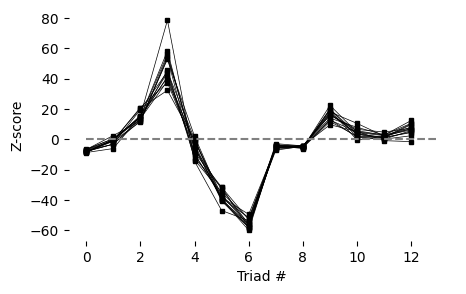

In [6]:
nrm_counts = (all_counts - all_er.mean()) / all_er.std()

fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.plot(nrm_counts.transpose(), color="black", lw=0.5, marker='s', ms=3)
ax.plot([0, 13], [0, 0], color="grey", ls="--")
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

Text(0, 0.5, 'Mean distance (um)')

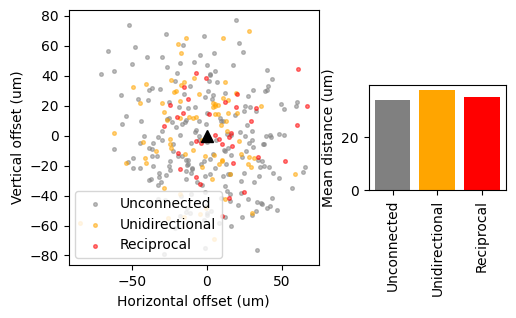

In [7]:
i = 0
d = all_deltas[i]
d = dict([(k, numpy.vstack(v)) for k, v in d.items()])
dists = dict([(k, numpy.linalg.norm(v, axis=1).mean()) for k, v in d.items()])

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])

def sample_random_fraction(arr_in, frac):
    assert frac <= 1
    b = numpy.random.choice(arr_in.shape[0], int(arr_in.shape[0] * frac), replace=False)
    return arr_in[b, 0], arr_in[b, 1]

ax.scatter(*sample_random_fraction(d["unconnected"], 0.1), c="grey", s=7, alpha=0.5, label="Unconnected")
ax.scatter(*sample_random_fraction(d["connected"], 0.1), c="orange", s=7, alpha=0.5, label="Unidirectional")
ax.scatter(*sample_random_fraction(d["reciprocal"], 0.1), c="red", s=7, alpha=0.5, label="Reciprocal")
ax.plot(0, 0, marker="^", ms=8, color="black")
ax.set_xlabel("Horizontal offset (um)")
ax.set_ylabel("Vertical offset (um)")
plt.axis("equal")
plt.legend()

ax = fig.add_axes([0.7, 0.35, 0.275, 0.35])
ax.bar(2, dists["reciprocal"], color="red")
ax.bar(1, dists["connected"], color="orange")
ax.bar(0, dists["unconnected"], color="grey")
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["Unconnected", "Unidirectional", "Reciprocal"], rotation="vertical")
ax.set_ylabel("Mean distance (um)")